# Use Case 7: Trans genetic effects

In order to show more of what we can do with our mutation data, we want to explore [transgenetic effects](https://en.wikipedia.org/wiki/Trans-acting). This occurs when DNA mutation in one gene has an effect on a ifferent gene. Therefore, to fully understand the effect of DNA mutation, we need to look at the proteins that interact with our mutated protein, as well as the ones that may be involved later on in a process. This use case will show how to find some of those protiens. In this use case we'll explore two prominent cancer genes: TP53 and ARID1A.

# Part I: TP53

TP53 is a tumor suppressing gene that is very important in helping prevent mutation, as well as repairing damaged DNA in cells. Attached [here](https://en.wikipedia.org/wiki/P53) is a wikipedia article for a further introduction of TP53.

# Step 1: Import Libraries

Here we will import standard python libraries used to analyze and visualize data as pandas dataframes, as well as our CPTAC data.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

import cptac
import cptac.utils as al

en = cptac.Endometrial()

Our analysis here will be done with endometrial cancer, because we know that mutations in TP53 have been shown to be especially important in endometrial cancer, but can also be done across all of the other cancers in the dataset.

In [2]:
gene = "TP53"
omics = "proteomics"

# Step 2: Get Interacting Proteins

Now we will get a list of the proteins that are know to interact with TP53 directly. The method identified here, the bioplex method, is a process that identifies proteins that come into direct physical contact. When we call the get_interacting_proteins_bioplex method, this returns a list of proteins that interact with our gene in this way.

In [3]:
interacting_proteins = al.get_interacting_proteins_bioplex(gene)

print("Interacting Proteins:")
print(interacting_proteins)

Interacting Proteins:
['MDM4', 'FAM111A', 'HOMER3', 'GPR156', 'CUL9', 'CUL7', 'FAM175B', 'AURKA', 'CELA2B', 'HNF4A', 'FBXW7', 'RORC', 'MDM2']


# Step 3: Get Omics Data

Now we create a new dataframe containing protein measurements for the interacting proteins that we are interested in. We start by calling en.join_omics_to_mutations in order to join our TP53 mutations dataframe with our proteomics dataframe. 

In [4]:
protdf = en.join_omics_to_mutations(mutations_genes=[gene], omics_df_name=omics, omics_genes=interacting_proteins)
protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']

In [5]:
protdf.head()

Name,MDM4_proteomics,FAM111A_proteomics,HOMER3_proteomics,GPR156_proteomics,CUL9_proteomics,CUL7_proteomics,FAM175B_proteomics,AURKA_proteomics,CELA2B_proteomics,HNF4A_proteomics,FBXW7_proteomics,RORC_proteomics,MDM2_proteomics,TP53_Mutation,TP53_Location,TP53_Mutation_Status,Sample_Status
Sample_ID,,,,,,,,,,,,,,,,,
S001,NaN,0.363000,-0.443,NaN,0.0355,0.0408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Missense_Mutation],[p.R248W],Single_mutation,Tumor
S002,NaN,0.601000,-0.897,NaN,0.1480,-0.1430,NaN,0.311,NaN,NaN,NaN,NaN,NaN,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor
S003,NaN,-0.280000,-0.451,NaN,0.1130,0.0999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor
S005,NaN,0.066500,-0.034,NaN,0.1680,-0.7460,NaN,-0.798,NaN,NaN,NaN,NaN,NaN,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor
S006,NaN,-0.000411,-0.535,NaN,-0.2530,-0.1200,NaN,3.110,NaN,NaN,NaN,NaN,NaN,[Missense_Mutation],[p.S241C],Single_mutation,Tumor


Next, since in order to make comparisons we will want our "TP53 Mutation Status" column to contain one of two values- either "Mutated" or "Wildtype." We will then delete other columns

In [6]:
for ind, row in protdf.iterrows():
    if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
        protdf.at[ind,'TP53 Mutation Status'] = 'Mutated'
    else:
        protdf.at[ind,'TP53 Mutation Status'] = 'Wildtype'

Since we are only interested in interacting protein levels, here we trim down the dataframe and drop unwanted columns.

In [7]:
protdf = protdf.drop(gene+"_Mutation",axis=1)
protdf = protdf.drop(gene+"_Location",axis=1)
protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
protdf = protdf.drop("Sample_Status",axis=1)

We take the column names, which are the interacting proteins, and create a list in order to run our t-tests for each protein individually.

In [8]:
col_list = list(protdf.columns)
col_list.remove('TP53 Mutation Status')

In [9]:
print(col_list)

['MDM4_proteomics', 'FAM111A_proteomics', 'HOMER3_proteomics', 'GPR156_proteomics', 'CUL9_proteomics', 'CUL7_proteomics', 'FAM175B_proteomics', 'AURKA_proteomics', 'CELA2B_proteomics', 'HNF4A_proteomics', 'FBXW7_proteomics', 'RORC_proteomics', 'MDM2_proteomics']


Now we call wrap_ttest, which is an accessory function in cptac.utils. It expects one column with a binary variable (which is 'TP53 Mutation Status' for us as either mutated or wildtype), and all other data as qualitiative. It will then run ttests to determine if there is a statistically significant difference between the binary values and their respective qualitative data. For our case, it will tell us if there are significantly different measurements between wildtype and mutated samples.

# Step 4: Do T-tests

In [10]:
print("Doing t-test comparisons\n")
wrap_results = al.wrap_ttest(protdf, 'TP53 Mutation Status', col_list)
#This gives us back a dataframe with significant comparisons

if wrap_results is not None:
        print(wrap_results)
        print("\n\n")

Doing t-test comparisons

1 significant comparisons!
         Comparison   P_Value
0  AURKA_proteomics  0.000016





Our t-test returned one protein whose levels were significantly changed by a mutation in TP53, Aurora Kinase, which has a known [relationship](https://www.ncbi.nlm.nih.gov/pubmed/27933271) with TP53. We will now create a boxplot to show exactly how levels of aurora kinase change with our gene's mutation. We will do so with the seaborn library, as a stripplot on top of a boxplot. Our data is given by the "protdf" dataframe that we created earlier.

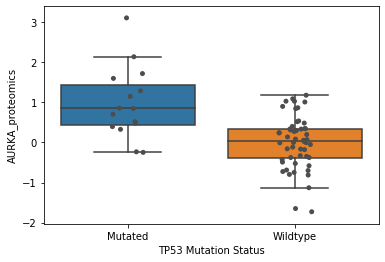

In [11]:
sns.boxplot(data = protdf, x = 'TP53 Mutation Status', y = 'AURKA_proteomics', showfliers = False)
sns.stripplot(data = protdf, x = 'TP53 Mutation Status', y = 'AURKA_proteomics', jitter = True, dodge = True, color = '.3')

From this boxplot, we can see that there is a significant increase in aurora kinase levels with a mutation in TP53.

# Part II: Example Using ARID1A

We will now look at ARID1A, which potentially affects the transcription of many genes through its function as a chromatin remodeling protein. Attached [here](https://en.wikipedia.org/wiki/ARID1A) is a wikipedia article about ARID1A.

In order to perform this analysis, we will use the same steps as we did earlier, only this time without separated code blocks. The following code box will go through thousands of proteins contained in our dataset and look at how a mutation in ARID1A affects them. Because of the high amount of comparisons, this will take a little bit of time. In the end, we will have a list of genes affected by ARID1A.

In [12]:
gene = "ARID1A"
print("\nGene: ", gene)

# Step 1: Create dataframe in order to do comparisons with wrap_ttest
protdf = en.join_omics_to_mutations(mutations_genes=[gene], omics_df_name=omics)
protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']

for ind, row in protdf.iterrows():
    if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
        protdf.at[ind,'ARID1A Mutation Status'] = 'Mutated'
    else:
        protdf.at[ind,'ARID1A Mutation Status'] = 'Wildtype'

        
# Step 2: Format the dataframe to set it up properly for our t-test
protdf = protdf.drop(gene+"_Mutation",axis=1)
protdf = protdf.drop(gene+"_Location",axis=1)
protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
protdf = protdf.drop("Sample_Status",axis=1)


#Step 3: Make list of columns to be compared using t-tests
col_list = list(protdf.columns)
col_list.remove('ARID1A Mutation Status')

    
#Step 4: Call wrap_ttest, pass in formatted dataframe, print results
print("Doing t-test comparisons\n")
wrap_results = al.wrap_ttest(protdf, 'ARID1A Mutation Status', col_list)

if wrap_results is not None:
        print(wrap_results)
        print("\n\n")


Gene:  ARID1A


Doing t-test comparisons



/Users/kimball.benjamin1/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/kimball.benjamin1/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


8 significant comparisons!
          Comparison       P_Value
0  ARID1A_proteomics  1.025018e-10
1   MAP1S_proteomics  1.010149e-07
2    DPF2_proteomics  2.166609e-07
3   KDM4B_proteomics  4.414547e-07
4    RRM1_proteomics  4.455870e-07
5  MAP7D3_proteomics  4.880890e-07
6   CYTH3_proteomics  3.109396e-06
7   CEP78_proteomics  3.749172e-06





Each of the proteins shown can be individually analyzed in the same manner that we showed above. The reason for the relatively small list of proteins shown here is that our wrap_ttest does Bonferroni correction, so the cutoff for "significance" is very strict. For further ideas about how to analyze larger lists of genes, refer to usecase 5.